In [52]:
from transpile_benchy.interface import QASMBench, RedQueen
from transpile_benchy.interface import MQTBench


qasm_bench_s = QASMBench(size="small")

# redqueen = RedQueen()

from transpile_benchy.metrics import DepthMetric
from qiskit.circuit.library import iSwapGate

depth_metric = DepthMetric(basis_gate=iSwapGate().power(1 / 2))

from qiskit.transpiler import CouplingMap

# coupling_map = CouplingMap.from_grid(3,3)


# coupling_map = CouplingMap.from_heavy_hex(5)

from virtual_swap.pass_managers import SabreVS, SabreQiskit, QiskitLevel3

In [53]:
# metric for counting percent of accepted substitutions
from transpile_benchy.metrics import MetricInterface


class SubsMetric(MetricInterface):
    """Calculate the depth of a circuit."""

    def __init__(self):
        """Initialize the metric."""
        self.name = "accepted_subs"
        self.transpiler_pass = None

    def get_pass(self):
        """Return the pass associated with this metric."""
        return self.transpiler_pass

In [54]:
coupling_map = CouplingMap.from_line(8)
filter_list = ["fredkin", "toffoli", "adder_n4"]
qasm_bench_m = QASMBench(size="small", filter_list=filter_list)
filter_list = ["\\bqaoa", "qft", "shor", "dj", "ae", "qgan"]
mqt_bench = MQTBench(num_qubits=8, filter_list=filter_list)

In [55]:
# coupling_map = CouplingMap.from_grid(6,6)
# filter_list = None
# qasm_bench_m = QASMBench(size="medium", filter_list=filter_list)
# filter_list = ["\\bqaoa", "qft", "shor", "dj", "ae", "qgan", "qpe"]
# filter_list = ["None"]
# mqt_bench = MQTBench(num_qubits=8, filter_list=filter_list)

In [56]:
# mqt = []
# mqt.append(MQTBench(num_qubits=16, filter_str="qaoa"))
# mqt.append(MQTBench(num_qubits=16, filter_str="qft"))
# mqt.append(MQTBench(num_qubits=16, filter_str="hhl"))

# coupling_map = CouplingMap.from_grid(4, 4)

In [57]:
from qiskit.circuit.library import CXGate, iSwapGate
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
from transpile_benchy.interface import QiskitFunctionInterface
from qiskit.circuit.library import TwoLocal

num_qubits = 8
coupling_map = CouplingMap.from_line(num_qubits)
# coupling_map = CouplingMap.from_grid(3, 3)


def create_TwoLocal_function(
    entanglement_blocks, entanglement_name, entanglement_type="full", reps=2
):
    """Generates a function to create a TwoLocal object with given parameters"""

    def TwoLocal_function(n_qubits):
        return TwoLocal(n_qubits, "ry", entanglement_blocks, entanglement_type, reps)

    TwoLocal_function.__name__ = (
        # f"TwoLocal_{entanglement_type}_{entanglement_name}_{reps}reps"
        f"TwoLocal-{entanglement_name}"
    )
    return TwoLocal_function


def generate_interface_from_data(data, qubits_options):
    """Generates a QiskitFunctionInterface from gate data and qubits options"""
    gate, name = data
    func = create_TwoLocal_function(gate, name)
    return QiskitFunctionInterface(func, qubits_options)


num_qubits_options = [num_qubits]  # Or any other options you'd like

# Specify the gate blocks and their names
entanglement_blocks_data = [
    (CXGate(), r"$\texttt{CNOT}$"),
    # (CXGate().power(1 / 2), r"$\sqrt{\texttt{CNOT}}$"),
    (iSwapGate(), r"$\texttt{iSWAP}$"),
    (iSwapGate().power(1 / 2), r"$\sqrt{\texttt{iSWAP}}$"),
    (UnitaryGate(canonical_gate(0.5, 0.25, 0.25).full()), r"$\texttt{ECP}$"),
]

qiskit_functions_twolocal = [
    generate_interface_from_data(data, num_qubits_options)
    for data in entanglement_blocks_data
]

In [58]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
# transpile_benchy_logger.setLevel(logging.INFO)
transpile_benchy_logger.setLevel(logging.WARNING)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        # SabreQiskit(coupling_map, cx_basis=True),
        QiskitLevel3(coupling_map, cx_basis=True),
        SabreVS(coupling_map, cx_basis=True),
        # SabreQiskit(coupling_map),
        QiskitLevel3(coupling_map),
        SabreVS(coupling_map, logger=transpile_benchy_logger),
    ],
    submodules=qiskit_functions_twolocal,
    # submodules=[qasm_bench_m, mqt_bench],
    metrics=[depth_metric, SubsMetric()],
    logger=transpile_benchy_logger,
    num_runs=5,
)

# submodules=[qasm_bench_s],
# submodules=[mqt],
# submodules=[
# MQTBench(num_qubits=4, filter_str="qaoa"),
# # MQTBench(num_qubits=8, filter_str="qaoa"),
# # MQTBench(num_qubits=12, filter_str="qaoa"),
# # MQTBench(num_qubits=16, filter_str="qaoa"),
# ],

benchmark.run()

Running circuits for QiskitFunctionInterface:   0%|          | 0/1 [00:00<?, ?it/s]

Running circuits for QiskitFunctionInterface: 100%|██████████| 1/1 [01:06<00:00, 66.33s/it]


In [59]:
# TODO filter add to results tracking, # number of added SWAPs, # of CNS subs
# remove the results if qiskit adds 0 SWAPS (can't be improved)
# reduce to a set of ~8 circuits at ~16Q scale....

In [60]:
# print(benchmark.results)

In [75]:
# find average improvement from 'Qiskit-$\\texttt{CNOT}$' to 'SABREVS-$\\texttt{CNOT}$'
# find average improvement from 'Qiskit-$\\sqrt{\\texttt{iSWAP}}$' to 'SABREVS-$\\sqrt{\\texttt{iSWAP}}$'
key = "monodromy_depth"
# key = 'accepted_subs'
l1 = list(
    x["Qiskit-$\\texttt{CNOT}$"].average
    for x in benchmark.results.results[key].values()
)
l2 = list(
    x["SABREVS-$\\texttt{CNOT}$"].average
    for x in benchmark.results.results[key].values()
)

l3 = list(
    x["Qiskit-$\\sqrt{\\texttt{iSWAP}}$"].average
    for x in benchmark.results.results[key].values()
)
l4 = list(
    x["SABREVS-$\\sqrt{\\texttt{iSWAP}}$"].average
    for x in benchmark.results.results[key].values()
)

# average element wise percent improvmement
print(sum((x - y) / x for x, y in zip(l1, l2)) / len(l1))
print(sum((x - y) / x for x, y in zip(l3, l4)) / len(l3))

0.5887315479169156
0.5558005586405549


In [76]:
l3 = list(
    x["Qiskit-$\\sqrt{\\texttt{iSWAP}}$"].average
    for x in benchmark.results.results[key].values()
)
l4 = list(
    x["SABREVS-$\\sqrt{\\texttt{iSWAP}}$"].average
    for x in benchmark.results.results[key].values()
)

In [77]:
print(l3)

[57.69684750546332, 85.697884801988, 43.596060168140745, 112.7984126817312]


In [78]:
print(l4)

[33.45012064190407, 21.291778494307948, 29.500000000000004, 30.672485360801648]


In [67]:
key = "accepted_subs"
l4 = list(
    x["SABREVS-$\\sqrt{\\texttt{iSWAP}}$"].average
    for x in benchmark.results.results[key].values()
)
# average
print(sum(l4) / len(l4))

0.8527272727272728


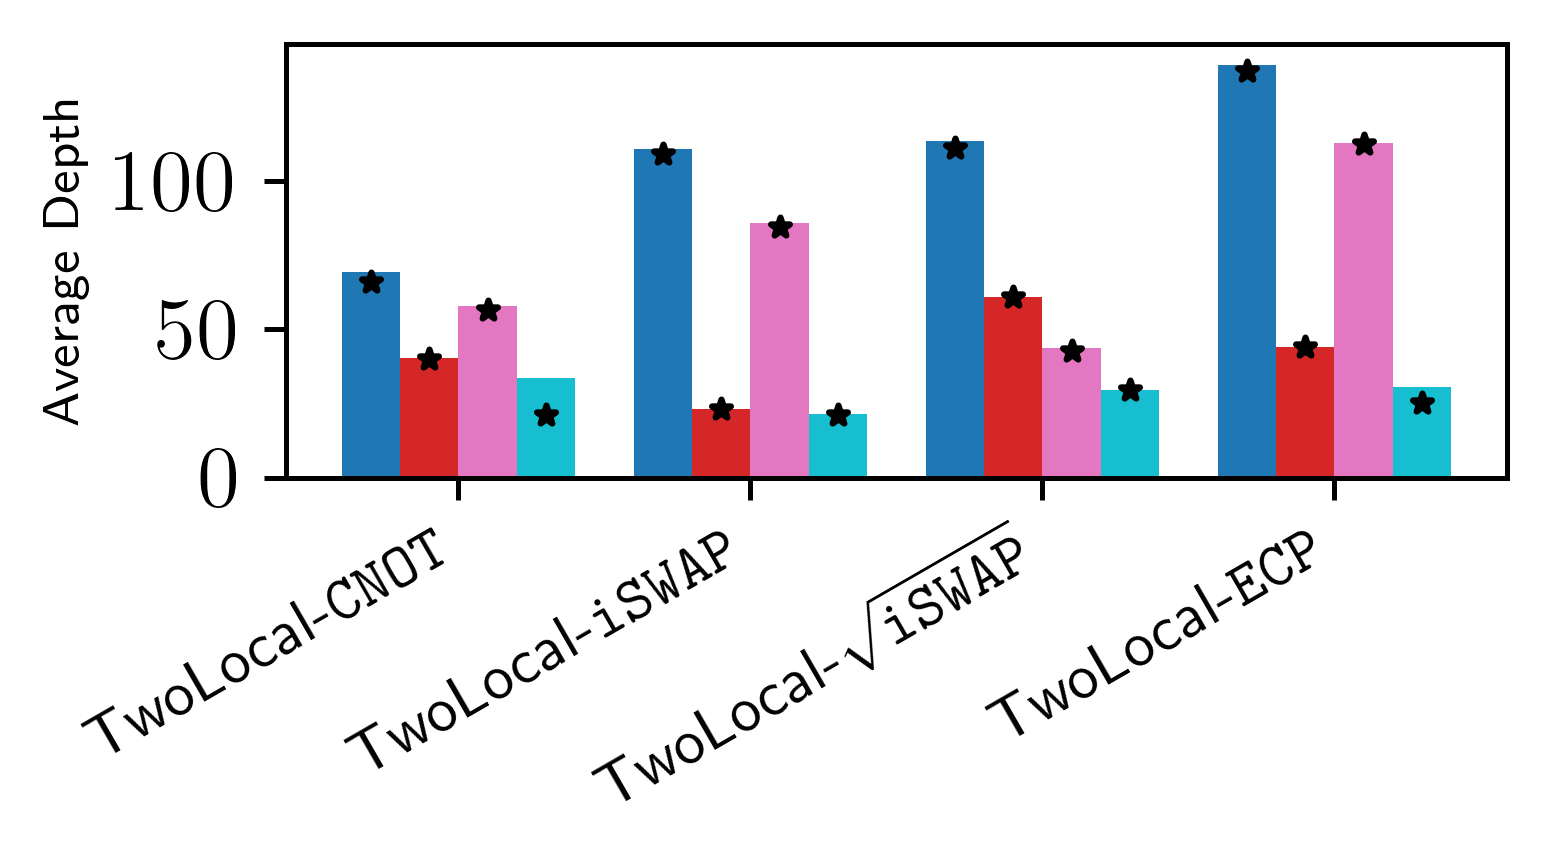

In [63]:
benchmark.plot(save=1, legend_show=0)

In [64]:
# from transpile_benchy.interface import QiskitFunctionInterface
# from qiskit.circuit.library import TwoLocal

# entanglement_types = ["linear", "full", "circular", "sca"]
# entanglement_types = ["full"] #, "reverse_linear"]


# def function_generator(entanglement_type):
#     def entanglement_function(n_qubits):
#         return TwoLocal(n_qubits, ["ry"], "cx", entanglement_type, reps=1)

#     entanglement_function.__name__ = f"TwoLocal_{entanglement_type}"
#     return entanglement_function


# num_qubits_options = [8]

# qiskit_functions_twolocal = [
#     QiskitFunctionInterface(function_generator(entanglement_type), num_qubits_options)
#     for entanglement_type in entanglement_types
# ]

# # 5Q backend = provider.backend.ibmq_quito
# # 20Q backend = provider.backend.ibmq_mumbai
# from typing import Callable, List
# from transpile_benchy.interface import QiskitFunctionInterface

# num_qubits = [8]  # , 20, 24, 28, 32, 36]
# from qiskit.circuit.library import QFT, QuantumVolume

# qiskit_functions_qft = QiskitFunctionInterface(QFT, num_qubits)
# qiskit_functions_qv = QiskitFunctionInterface(QuantumVolume, num_qubits)
# next(MQTBench(num_qubits=4, filter_str="qaoa").get_quantum_circuits()).draw('mpl', fold=-1)
# next(qasm_bench_m.get_quantum_circuits())

In [65]:
# from the literature
# toffoli
# fredkin
# EC codes
# Controlled phase
# QAOA
# Controlled phsae
# full entanling
# entanglemnt purification

# linaer, 2d, heavy-hex

# grover
# vqe
# bv
# qft
# qpe
# adder
# multipler
# sqn
# rd84
# co14
# sym9
# hub18
# shor26
# qaoa12
# tfim64
# tfxy64